In [1]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import Dataset

# Define your data directory and transformations
data_dir = "./data"
transform = transforms.Compose(
    [
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
    ]
)
# Create DataLoader
dataset = Dataset(data_dir="./data", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [3]:
iter = iter(dataloader)

In [4]:
imagePath, labels, segPath = next(iter)
trueSeg = Image.open(segPath[0])

In [13]:
imagePath

('/home/charbel/Desktop/stages/inmind.ai/material/week4-computervision/mywork/data/rgb_0630.png',)

In [5]:
import onnxruntime as ort
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

color_map_list = torch.tensor(
    [
        [0, 0, 0],
        [25, 82, 255],
        [255, 25, 197],
        [140, 255, 25],
        [0, 0, 0],
        [226, 255, 25],
        [255, 197, 25],
        [140, 25, 255],
        [54, 255, 25],
        [25, 255, 82],
        [255, 111, 25],
    ]
)

# Color map for converting RGB masks to class indices
color_map = {
    0: [0, 0, 0],
    1: [25, 82, 255],
    2: [255, 25, 197],
    3: [140, 255, 25],
    4: [226, 255, 25],
    5: [255, 197, 25],
    6: [140, 25, 255],
    7: [54, 255, 25],
    8: [25, 255, 82],
    9: [255, 111, 25],
}


def convert_rgb_to_class_index(mask, color_map=color_map):
    h, w, c = mask.shape
    mask_out = np.zeros((h, w), dtype=np.uint8)
    for class_idx, color in color_map.items():
        color = np.array(color)
        class_mask = np.all(mask == color, axis=-1)
        mask_out[class_mask] = class_idx
    return mask_out


def map_one_hot_to_image(one_hot, color_map=color_map_list):
    batch_size, height, width, num_colors = one_hot.shape

    # Use argmax to find the index of the 1 in each one-hot vector
    indices = torch.argmax(one_hot, dim=-1)

    # Use the indices to select colors from the color map
    output = color_map[indices]

    return output


def perform_inference(image_path, model_path, color_map=color_map_list):
    # Load the ONNX model
    session = ort.InferenceSession(model_path)
    # Load and preprocess the image
    image = Image.open(image_path)
    image = torch.tensor(np.expand_dims(np.array(image), axis=0), dtype=torch.float32)[
        :, :, :, :3
    ]
    resize = transforms.Resize((640, 640))
    image = image.permute(0, 3, 2, 1)
    image = resize(image)
    image = image.permute(0, 3, 2, 1) / 255

    # Perform inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: np.array(image)})
    outputs = torch.tensor(outputs[0][0]).permute(1, 2, 0)
    outputs = torch.tensor(np.expand_dims(np.array(outputs), axis=0))
    outputs = map_one_hot_to_image(outputs, color_map)
    return outputs, image


# Example usage:
# image_path = "./data/rgb_0009.png"
model_path = "./bestModels/fcn.onnx"
predSeg, image = perform_inference(imagePath[0], model_path)

In [6]:
import sys

sys.path.append("./yoloInference")
from yoloInference.detect import detect_objects

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


/home/charbel/.local/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
output, time = detect_objects(
    "./bestModels/yolo.pt",
    imagePath[0],
    conf_thres=0.35,
    iou_thres=0.45,
    img_size=640,
)

In [8]:
from plots import displayImagesWithBoxesYolo

In [9]:
boxes = [x[1:5] for x in output]
realBoxes = [x[1:5] for x in labels]

In [10]:
pred = displayImagesWithBoxesYolo(imagePath[0], boxes)
real = displayImagesWithBoxesYolo(imagePath[0], realBoxes)

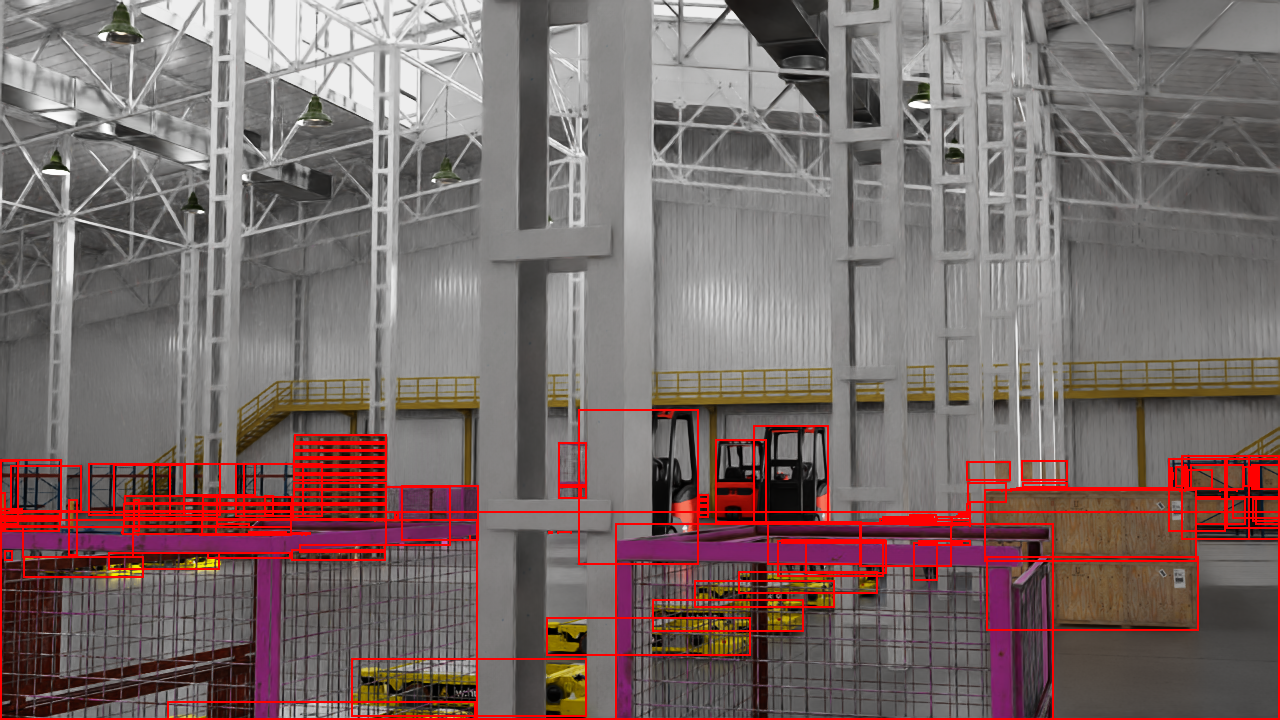

In [11]:
real

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the 5 images using subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1
axs[0, 0].imshow(image[0])
axs[0, 0].set_title("Original Image")

# Plot 2
axs[0, 1].imshow(predSeg[0])
axs[0, 1].set_title("predicted segmentation")

# Plot 3
axs[0, 2].imshow(np.array(pred))  # Convert pred to numpy array
axs[0, 2].set_title("predicted boxes")

# Plot 4
axs[1, 0].imshow(np.array(real))  # Convert real to numpy array
axs[1, 0].set_title("real boxes")

# Plot 5 - Add your fifth image here
axs[1, 1].imshow(trueSeg)  # Replace 'another_image' with the image you want to plot
axs[1, 1].set_title("segmented Image")

# Hide the last subplot
axs[1, 2].axis("off")

plt.savefig("./predictions.png")
plt.show()

/tmp/ipykernel_59048/575453982.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [13]:
### Import libraries
import numpy as np

# ... existing imports ...
from torchvision.ops import box_iou
import numpy as np

### Setup variables
iou_threshold = 0.5  # IoU threshold to consider a prediction as a true positive


## Model
### Function to calculate IoU between two boxes
def calculate_iou(box1, box2):
    # Convert from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
    box1_xmin = box1[0] - box1[2] / 2
    box1_ymin = box1[1] - box1[3] / 2
    box1_xmax = box1[0] + box1[2] / 2
    box1_ymax = box1[1] + box1[3] / 2

    box2_xmin = box2[0] - box2[2] / 2
    box2_ymin = box2[1] - box2[3] / 2
    box2_xmax = box2[0] + box2[2] / 2
    box2_ymax = box2[1] + box2[3] / 2

    # Calculate the intersection coordinates
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)

    # Calculate the area of intersection
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Calculate the area of both boxes
    box1_area = (box1_xmax - box1_xmin) * (box1_ymax - box1_ymin)
    box2_area = (box2_xmax - box2_xmin) * (box2_ymax - box2_ymin)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou


### Function to calculate Precision, Recall, and IoUs
def calculate_detection_metrics(true_boxes, pred_boxes):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_pred_indices = set()
    ious = []

    for true_box in true_boxes:
        best_iou = 0
        best_pred_idx = -1
        for idx, pred_box in enumerate(pred_boxes):
            if len(true_box) == 0 or len(pred_box) == 0:
                continue
            iou = calculate_iou(true_box, pred_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = idx

        ious.append(best_iou)

        if best_iou >= iou_threshold and best_pred_idx not in matched_pred_indices:
            true_positives += 1
            matched_pred_indices.add(best_pred_idx)
        else:
            false_negatives += 1

    false_positives = len(pred_boxes) - len(matched_pred_indices)

    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )

    return precision, recall, np.mean(ious)

In [14]:
def calculate_segmentation_metrics(true_labels, pred_labels, num_classes):
    """
    Calculate segmentation metrics such as IoU, Dice coefficient, and Pixel accuracy.

    Parameters:
    - true_labels: Ground truth segmented image (single-channel, shape: (640, 640))
    - pred_labels: Predicted segmented image (single-channel, shape: (640, 640))
    - num_classes: Number of classes including background.

    Returns:
    - A dictionary containing IoU, Dice coefficient, and Pixel accuracy for each class.
    """

    iou_list = []
    dice_list = []
    pixel_accuracy_list = []

    for cls in range(num_classes):
        # Create binary masks for the current class
        true_mask = (np.array(true_labels) == cls).astype(np.uint8)
        pred_mask = (np.array(pred_labels) == cls).astype(np.uint8)

        # Calculate Intersection and Union
        intersection = np.sum(true_mask * pred_mask)
        union = np.sum(true_mask) + np.sum(pred_mask) - intersection

        # Calculate metrics for the current class
        iou = intersection / union if union != 0 else 0
        dice = (
            2 * intersection / (np.sum(true_mask) + np.sum(pred_mask))
            if (np.sum(true_mask) + np.sum(pred_mask)) != 0
            else 0
        )
        pixel_accuracy = np.sum(true_mask == pred_mask) / true_labels.size

        iou_list.append(iou)
        dice_list.append(dice)
        pixel_accuracy_list.append(pixel_accuracy)

    ## Output
    ### Display the results
    return {
        "iou": np.mean(iou_list),
        "dice": np.mean(dice_list),
        "pixel_accuracy": np.mean(pixel_accuracy_list),
    }

In [24]:
image_size = 640  # The size of the image (640x640)

iou_threshold = 0.2  # IoU threshold to consider a prediction as a true positive


## Model
### Function to scale boxes from normalized to actual size
def scale_box(box, image_size):
    return [
        box[0] * image_size,  # x_center
        box[1] * image_size,  # y_center
        box[2] * image_size,  # width
        box[3] * image_size,  # height
    ]


### Function to calculate IoU between two boxes
def calculate_iou(box1, box2):
    # Convert from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
    box1_xmin = box1[0] - box1[2] / 2
    box1_ymin = box1[1] - box1[3] / 2
    box1_xmax = box1[0] + box1[2] / 2
    box1_ymax = box1[1] + box1[3] / 2

    box2_xmin = box2[0] - box2[2] / 2
    box2_ymin = box2[1] - box2[3] / 2
    box2_xmax = box2[0] + box2[2] / 2
    box2_ymax = box2[1] + box2[3] / 2

    # Calculate the intersection coordinates
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)

    # Calculate the area of intersection
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Calculate the area of both boxes
    box1_area = (box1_xmax - box1_xmin) * (box1_ymax - box1_ymin)
    box2_area = (box2_xmax - box2_xmin) * (box2_ymax - box2_ymin)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou


### Function to calculate Precision, Recall, and IoUs
def calculate_detection_metrics(true_boxes, pred_boxes):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_pred_indices = set()
    ious = []

    for true_box in true_boxes:
        best_iou = 0
        best_pred_idx = -1
        if len(true_box) == 0:
            continue
        scaled_true_box = scale_box(true_box, image_size)

        for idx, pred_box in enumerate(pred_boxes):
            if len(pred_box) == 0:
                continue

            scaled_pred_box = scale_box(pred_box, image_size)
            iou = calculate_iou(scaled_true_box, scaled_pred_box)

            if iou > best_iou:
                best_iou = iou
                best_pred_idx = idx

        ious.append(best_iou)

        if best_iou >= iou_threshold and best_pred_idx not in matched_pred_indices:
            true_positives += 1
            matched_pred_indices.add(best_pred_idx)
        else:
            false_negatives += 1

    false_positives = len(pred_boxes) - len(matched_pred_indices)

    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )

    return precision, recall, np.mean(ious)

In [25]:
# Initialize metrics
seg_ious, seg_accs, seg_dices = [], [], []
det_precisions, det_recalls, det_ious = [], [], []

counter = 0

# Loop through all images
for imagePath, labels, segPath in dataloader:
    counter += 1
    if counter == 10:
        break
    # Segmentation prediction
    predSeg, _ = perform_inference(imagePath[0], model_path)
    trueSeg = np.array(Image.open(segPath[0]).resize((640, 640)))[:, :, :3]

    metrics = calculate_segmentation_metrics(
        convert_rgb_to_class_index(trueSeg), convert_rgb_to_class_index(predSeg[0]), 10
    )
    iou = metrics["iou"]
    dice = metrics["dice"]
    pixAcc = metrics["pixel_accuracy"]

    seg_ious.append(iou)
    seg_dices.append(dice)
    seg_accs.append(pixAcc)

    # YOLO detection
    output, _ = detect_objects(
        "./bestModels/yolo.pt",
        imagePath[0],
        conf_thres=0.35,
        iou_thres=0.45,
        img_size=640,
    )
    if output != [] and labels != [] and labels[0] != []:
        pred_boxes = [x[1:5] for x in output if output != []]
        true_boxes = [x[1:5] for x in labels[0]]
        # Calculate detection metrics
        precision, recall, iou = calculate_detection_metrics(true_boxes, pred_boxes)
        det_precisions.append(precision)
        det_recalls.append(recall)
        det_ious.append(iou)

# Calculate average metrics
avg_seg_iou = np.mean(seg_ious)
avg_seg_accs = np.mean(seg_accs)
avg_seg_dices = np.mean(seg_dices)
avg_det_precision = np.mean(det_precisions)
avg_det_recall = np.mean(det_recalls)
avg_det_ious = np.mean(det_ious)

# Print results
print()
print(f"Segmentation Metrics:")
print(f"Average IoU: {avg_seg_iou:.4f}")
print(f"Average dice: {avg_seg_dices:.4f}")
print(f"\nDetection Metrics:")
print(f"Average Precision: {avg_det_precision:.4f}")
print(f"Average Recall: {avg_det_recall:.4f}")
print(f"Average F1 Score: {avg_det_ious:.4f}")

# ... existing code for visualization ...


Segmentation Metrics:
Average IoU: 0.0892
Average dice: 0.0940

Detection Metrics:
Average Precision: 0.0000
Average Recall: 0.0000
Average F1 Score: nan


In [18]:
[x[1:5] for x in labels[0] ]

SyntaxError: invalid syntax (132089865.py, line 1)

The output of the function below, i did not know how to process it , it needs non max suppression and confidence deletion but i did not understand the output 
Here i used onnx format to do inference

In [ ]:
def yoloInference(image_path, model_path):
    # Load the ONNX model
    session = ort.InferenceSession(model_path)
    print("modelread")
    image = Image.open(image_path)
    image_tensor = torch.tensor(
        np.expand_dims(np.array(image)[:, :, :3], axis=0), dtype=torch.float32
    )  # Add batch dimension
    image_tensor = image_tensor.permute(0, 3, 1, 2)

    resize = transforms.Resize((640, 640))  # Define resize transformation
    image_tensor = resize(image_tensor)

    # Perform inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: np.array(image_tensor)})
    return outputs

In [ ]:
output = yoloInference(image_path, "./bestModels/yolo.onnx")

Here i used torchscript.pt to run inferences but also i did not understand the output like before

In [ ]:
## Input
### Import libraries
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch

### Setup variables
onnx_model_path = "./bestModels/yolo.onnx"  # Path to your ONNX model
image_path = "./data/rgb_0006.png"
path = "./bestModels/best.torchscript.pt"

# Load the YOLO model from the ONNX file
# model = YOLO(onnx_model_path)
model = torch.jit.load("./bestModels/yolo.torchscript.pt")
model.task = "detect"
# Export to PyTorch format

# Now try using the exported PyTorch model
image = np.array(Image.open(image_path))[:, :, :3]
image_tensor = torch.tensor(
    np.expand_dims(np.array(image)[:, :, :3], axis=0), dtype=torch.float32
)  # Add batch dimension
image_tensor = image_tensor.permute(0, 3, 1, 2)
resize = transforms.Resize((640, 640))  # Define resize transformation
image_tensor = resize(image_tensor)
image_tensor = torch.tensor(image_tensor, dtype=torch.float32)
output = model(image_tensor)